In [1]:
from keras.applications.vgg16 import VGG16
model= VGG16('cats_and_dogs_small_2.h5')

Using TensorFlow backend.


In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,decode_predictions
import numpy as np

img_path = 'C:/Users/willk/Desktop/Kim/practice/cat1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x=preprocess_input(x)

In [3]:
preds = model.predict(x)

In [4]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02123045', 'tabby', 0.6110605), ('n02124075', 'Egyptian_cat', 0.19213904), ('n02123159', 'tiger_cat', 0.15950304)]


In [5]:
np.argmax(preds[0])

281

In [6]:
from keras import backend as K
dog_or_cat_output = model.output[:, 263]

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(dog_or_cat_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2)) # loss

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

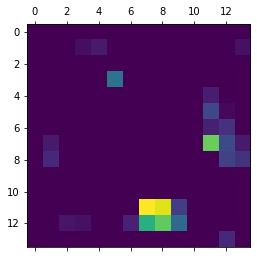

In [7]:
import matplotlib.pyplot as plt
heatmap = np.mean(conv_layer_output_value, axis=-1) # 마지막 axis
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [8]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
layer_name = 'block4_conv2'
filter_index = 0
layer_output = model.get_layer(layer_name).output # (?,?,?,256)
loss = K.mean(layer_output[:, :, :, filter_index]) # 0

In [10]:
grads = K.gradients(loss, model.input)[0]

In [11]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [12]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [13]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [14]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [15]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # L2

    iterate = K.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    
    for i in range(40): # Runs gradient ascent for 40 steps
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img) # numpy→image format

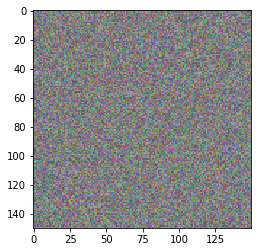

In [16]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block4_conv2', 0))